In [ ]:
######Import required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
import seaborn as sns
import random
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  #import KMeans library from sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import mpl_toolkits.mplot3d.axes3d as p3

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.utils import shuffle
import random
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import torch.nn as nn
import glob




#####defined functions#########

#!/usr/bin/python
'''
airPLS.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
Baseline correction using adaptive iteratively reweighted penalized least squares

This program is a translation in python of the R source code of airPLS version 2.0
by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
Reference:
Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

Description from the original documentation:

Baseline drift always blurs or even swamps signals and deteriorates analytical results, particularly in multivariate analysis.  It is necessary to correct baseline drift to perform further data analysis. Simple or modified polynomial fitting has been found to be effective in some extent. However, this method requires user intervention and prone to variability especially in low signal-to-noise ratio environments. The proposed adaptive iteratively reweighted Penalized Least Squares (airPLS) algorithm doesn't require any user intervention and prior information, such as detected peaks. It iteratively changes weights of sum squares errors (SSE) between the fitted baseline and original signals, and the weights of SSE are obtained adaptively using between previously fitted baseline and original signals. This baseline estimator is general, fast and flexible in fitting baseline.


LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
'''

import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties

    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting

    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax):
               print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn)
        w[-1]=w[0]
    return z



# 1 is assigned to spikes, 0 to non-spikes:

def z_score(intensity):
 mean_int = np.mean(intensity)
 std_int = np.std(intensity)
 z_scores = (intensity - mean_int) / std_int
 return z_scores

def modified_z_score(intensity):
 median_int = np.median(intensity)
 mad_int = np.median([np.abs(intensity-median_int)])
 modified_z_scores = 0.6745 * (intensity-median_int) / mad_int
 return modified_z_scores


def fixer(y,m):
 threshold = 1.5 # binarization threshold.
 delta_intensity=[]
 for i in np.arange(len(y)-1):
     dist = y[i+1] - y[i]
     delta_intensity.append(dist)
     delta_int = np.array(delta_intensity)
 spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
 y_out = y.copy() # So we don’t overwrite y
 for i in np.arange(len(spikes)-20):
  if spikes[i] != 0: # If we have an spike in position i
   w = np.arange(i-m,i+m+1) # we select 2 m + 1 points around our spike
   w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
        # From such interval, we choose the ones which are not spikes
   y_out[i] = np.mean(y[w2]) # and we average their values

 return y_out


####I defined this function for removing the spkies
###Change the threshold


def my_fixer(y,radius=8,n=4,threshold=3,distance=60):
    import scipy
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(y,  distance=distance) #use scipy to find the location of maximum spkies
    y_new=y.copy()
    s_peaks=[]
    for peak in peaks:
        yy=np.concatenate((y_new[peak-radius-n:peak-n],y_new[peak+n:peak+radius+n]))
        men=yy.mean()
        mex=yy.max()
        if (y_new[peak]-men)/(mex-men)>threshold:
            s_peaks.append(peak)
            y_new[peak-n:peak+n]=men
    return y_new


def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]

    return (data_msc, ref)


def snv(input_data):

    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###Creating input and output directoreis########

#Specify the input directroty
input_dir_raman='/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL'


###specify the root directory where you want to save your plots
output_path = os.path.join(input_dir_raman,'Results')

if not os.path.exists(output_path):
    os.mkdir(output_path)
    print('Results directory created')

output_path_baseline = os.path.join(output_path ,'Baseline_corrected')
if not os.path.exists(output_path_baseline):
    os.mkdir(output_path_baseline)
    print('Baseline results directory created')

output_path_baseline_normalized = os.path.join(output_path ,'Baseline_corrected_normalized')
if not os.path.exists(output_path_baseline_normalized):
    os.mkdir(output_path_baseline_normalized)
    print('Baseline_normalized results directory created')


output_path_plots= os.path.join(output_path ,'Plots')
if not os.path.exists(output_path_plots):
    os.mkdir(output_path_plots)
    print('plots directory created')


data_path_raman = os.path.join(input_dir_raman,'*.txt') ###detect files with txt format
files_raman_all = glob.glob(data_path_raman) ###All the files with *txt extension
files_raman_all.sort() ###sort files

Results directory created
Baseline results directory created
Baseline_normalized results directory created
plots directory created


Text(0, 0.5, 'Intensity (A.U.)')

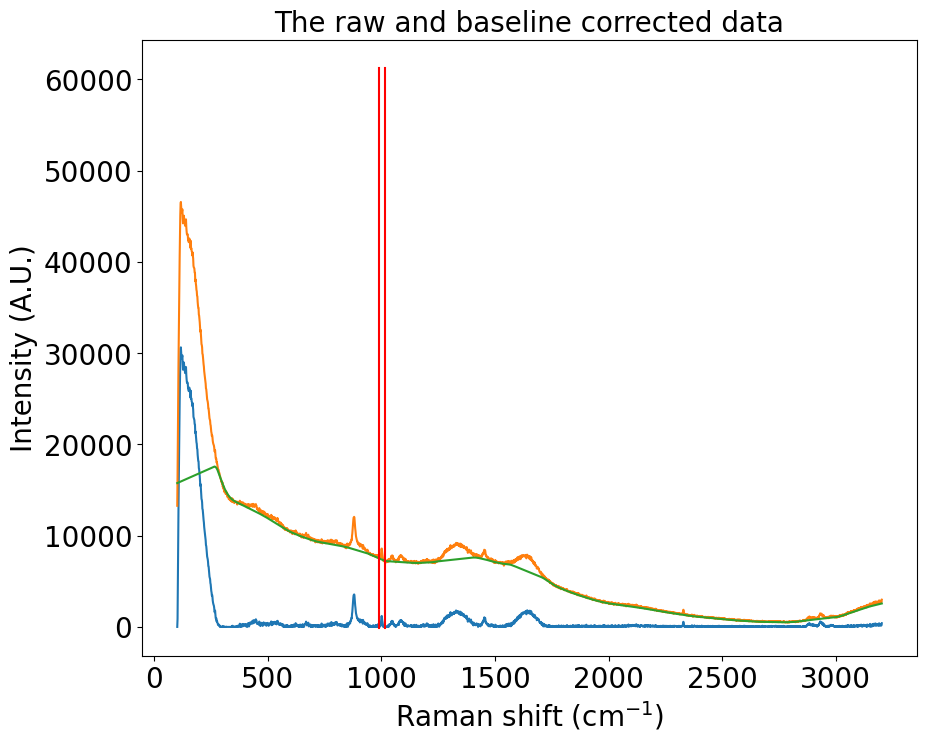

In [ ]:
###check for the values of start and end points for the region of interest
#### ckeck for the values of lambda to see how basline corrction looks like

len_raman=3194 ##len Raman
lamb_raman=np.loadtxt(files_raman_all[0])[0:len_raman,2]

###if you want to remove some of the initial points changes this len_raman to for example 3190
len_arbitray=len_raman
I_raman_raw=[]
I_baseline_corrected=[]

###lambda for baseline correction
lambda_=95

for f in files_raman_all[0:2]:
    I=np.loadtxt(f)[:,3] ##reading the intensity column
    nn=int(len(I)/len_raman) ### nn=number of signals in the third columns
    for n in range(nn):
        II=I[n*len_raman:n*len_raman+len_arbitray] ### the intensity
        I_raman_raw.append(II)
        II_b=II.copy()
        if  II.sum()!=0:
            II_b=II_b-airPLS(II_b,lambda_=lambda_) ###baseline corrected
            jj=-1
            ##remove this section if you don't want to remove zeros
            for ii in II_b:
                jj=jj+1
                if ii<0:
                   II_b[jj]=0
            ########################
            I_baseline_corrected.append(II_b)
            II_n=II_b.copy()
####you can check where your starting and end points for the region of interest are
###red lines demonstrate s and e
###after choosing ss and ee you can go to the next block and change the values of s and e

##ss=start
##ee=end
ss=2447
ee=2471

import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.subplots(figsize=(10,8))



plt.plot(lamb_raman,I_baseline_corrected[0])
plt.plot(lamb_raman,I_raman_raw[0])
plt.plot(lamb_raman,airPLS(I_raman_raw[0],lambda_=100))

plt.plot((np.ones((1,100))*lamb_raman[ss].reshape(-1))[0],np.linspace(-100,np.max(I_baseline_corrected[0])*2,100).reshape(-1),color='red')
plt.plot((np.ones((1,100))*lamb_raman[ee].reshape(-1))[0],np.linspace(-100,np.max(I_baseline_corrected[0])*2,100).reshape(-1),color='red')

plt.title('The raw and baseline corrected data',fontsize=20)

plt.xlabel('Raman shift (cm$^{-1}$)',fontsize=20)
plt.ylabel('Intensity (A.U.)',fontsize=20)

In [ ]:
len_raman=3194 ##len Raman
lamb_raman=np.loadtxt(files_raman_all[0])[0:len_raman,2]


###if you want to remove some of the initial points changes this len_raman to for example 3190
len_arbitray=len_raman
#lamb_raman=np.loadtxt(files_raman_all[0])[0:len_arbitray,2]


delta_lamb=lamb_raman[:-1]-lamb_raman[1:]

###for stroting intensities
I_normalized=[]
I_baseline_corrected=[]
I_raman_raw=[]

##for storing areas
areas_baseline=[]
areas_baseline_normalized=[]
areas_raw=[]
areas_raw_short=[]
areas_baseline_short=[]
areas_baseline_normalized_short=[]

###values to select the peak arounbd 2900
s=2447 ##start index of the region of interest
e=2471##end  index of the region of interest
##########
i=-1



from scipy import integrate
######
headers=[]
##for creating header for the files

for f in files_raman_all:
    I=np.loadtxt(f)[:,3] ##reading the intensity column
    nn=int(len(I)/len_raman) ### nn=number of signals in the third columns
    for n in range(nn):
        II=I[n*len_raman:n*len_raman+len_arbitray] ### the intensity
        I_raman_raw.append(II)
        headers.append(f+'_{}'.format(n)) ###stroing the last 20 letters of each file name as the indicator of the level
       #II=fixer(II,15)
        II=my_fixer(II,15,threshold=2) ###removing spikes
        II_b=II.copy()
        if  II.sum()!=0:
            areas_raw.append(integrate.simps(np.flip(II), np.flip(lamb_raman)))
            areas_raw_short.append(integrate.simps(np.flip(II[s:e]), np.flip(lamb_raman[s:e])))
            II_b=II_b-airPLS(II_b,lambda_=95) ###baseline corrected
            jj=-1
            ##remove this section if you don't want to remove zeros
            for ii in II_b:
                jj=jj+1
                if ii<0:
                   II_b[jj]=0
            ########################
            I_baseline_corrected.append(II_b)
            II_n=II_b.copy()
            areas_baseline.append(integrate.simps(np.flip(II_b),np.flip(lamb_raman)))
            areas_baseline_short.append(integrate.simps(np.flip(II_b[s:e]),np.flip(lamb_raman[s:e])))
            II_n=(II_n-II_n.mean())/II_n.std() ###Normalizing the data
            II_n=II_n-II_n.min()
            #II_n=snv(II_n.reshape(1,-1))[0]
            #II_n=msc(II_n.reshape(1,-1))[0][0]
            I_normalized.append(II_n)
            areas_baseline_normalized.append(integrate.simps(np.flip(II_n),np.flip(lamb_raman)))
            areas_baseline_normalized_short.append(integrate.simps(np.flip(II_n[s:e]),np.flip(lamb_raman[s:e])))


###convert to numpy array
I_baseline_corrected=np.array(I_baseline_corrected)
I_normalized= np.array(I_normalized)
areas_raw=np.array(areas_raw)
areas_raw_short=np.array(areas_raw_short)
areas_baseline=np.array(areas_baseline)
areas_baseline_short=np.array(areas_baseline_short)
areas_baseline_normalized=np.array(areas_baseline_normalized)
areas_baseline_normalized_short=np.array(areas_baseline_normalized_short)

In [ ]:
####saving the corrected data an area to csv########

data_n={}
data_b={}
areas_b={}
areas_b_short={}
areas_n={}
areas_n_short={}
j=-1
for h in headers:
    j=j+1
    data_n[h]=I_normalized[j,:].reshape(-1)
    data_b[h]=I_baseline_corrected[j,:].reshape(-1)
    areas_b_short[h]=areas_baseline_short[j].reshape(-1)
    areas_n_short[h]=areas_baseline_normalized_short[j].reshape(-1)
    areas_n[h]=areas_baseline_normalized[j].reshape(-1)
    areas_b[h]=areas_baseline[j].reshape(-1)


data_n=pd.DataFrame(data_n)
areas_n=pd.DataFrame(areas_n)
areas_n_short=pd.DataFrame(areas_n_short)
areas_b=pd.DataFrame(areas_b)
areas_b_short=pd.DataFrame(areas_b_short)

os.chdir(output_path_baseline_normalized)
data_n.to_csv('data_Raman.csv')
areas_n.to_csv('areas.csv')
areas_n_short.to_csv('areas_short_start{}_end{}.csv'.format(s,e))

data_b=pd.DataFrame(data_b)
os.chdir(output_path_baseline)
data_b.to_csv('data_Raman.csv')
areas_b.to_csv('areas.csv')
areas_b_short.to_csv('areas_short_start{}_end{}.csv'.format(s,e))



In [ ]:
areas_b_short.head()

,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_1,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_2,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_3,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_4,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_5,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_7,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_1,...,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_7,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_1,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_2,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_3,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_4,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_5,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_7
0,1962.260629,2293.9294,2012.77632,2378.160511,2259.739665,2467.622323,1634.749986,2459.015932,2918.949934,2719.721701,...,7577.577965,2737.960263,2524.506244,2629.552448,2534.525142,2311.635056,1909.158104,6937.30066,2366.578708,2524.740471


In [ ]:
areas_n_short.head()

,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_1,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_2,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_3,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_4,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_5,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (1).txt_7,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_1,...,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata (2).txt_7,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_0,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_1,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_2,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_3,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_4,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_5,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_6,/content/drive/MyDrive/Polystyrene Nanoparticles/100 nm/5) 5.96E+11 part mL/PSNPs_100nm_5.96x10^11_5x_785 nm_300mW_10s_350uL_8scans_rawdata.txt_7
0,0.514338,0.605777,0.529638,0.635016,0.615091,0.666133,0.442569,0.700085,0.757081,0.704804,...,2.038957,0.72797,0.684141,0.890273,0.679839,0.637456,0.52736,1.899506,0.656699,0.716282


In [ ]:
####Calculating prercent variations and saving them

#index of the peak value
peak_chosen=420

a_raw=np.array(areas_raw)
a_baseline=np.array(areas_baseline)


a_raw_short=np.array(areas_raw_short)
a_baseline_short=np.array(areas_baseline_short)


"""
a_raw=areas_raw-areas_raw.min()
a_baseline=areas_baseline-areas_baseline.min()

a_raw_short=areas_raw_short-areas_raw_short.min()
a_baseline_short=areas_baseline_short-areas_baseline_short.min()
"""

###for rounding numbers#######

def formatNumber(n, digits):
    formatter = '{:.' + '{}'.format(digits) + 'f}'
    x = round(n, digits)
    return formatter.format(x)


print('percent change of the areas of the raw data=', formatNumber(a_raw.std()/a_raw.max()*100,3))
print('max area of the raw data=', formatNumber(a_raw.max(),3))
print('min area of the raw data=', formatNumber(a_raw.min(),3))
print('percent change of the areas of the raw data short=',formatNumber(a_raw_short.std()/a_raw_short.max()*100,3))
print('max area of the raw data short=', formatNumber(a_raw_short.max(),3))
print('min area of the raw data short=', formatNumber(a_raw_short.min(),3))

peaks_values=[]
for i in range(int(len(I_raman_raw))):
    peaks_values.append(I_raman_raw[i][peak_chosen])

#plt.plot(peaks_values)

peaks_values=np.array(peaks_values)
print('percent change of the intensities of the raw data=', formatNumber(peaks_values.std()/peaks_values.max()*100,3))
print('max intensities of the raw data=', formatNumber(peaks_values.max(),3))
print('min intensities of the raw data=', formatNumber(peaks_values.min(),3))


datas={}
datas['percent change of the areas of the raw data']=formatNumber(a_raw.std()/a_raw.max()*100,3)
datas['max area of the raw data']=formatNumber(a_raw.max(),3)
datas['min area of the raw data']=formatNumber(a_raw.min(),3)
datas['percent change of the areas of the raw data short']=formatNumber(a_raw_short.std()/a_raw_short.max()*100,3)
datas['max area of the raw data short']=formatNumber(a_raw_short.max(),3)
datas['min area of the raw data short']=formatNumber(a_raw_short.min(),3)
datas['percent change of the intensities of the raw data']=formatNumber(peaks_values.std()/peaks_values.max()*100,3)
datas['max intensities of the raw data']=formatNumber(peaks_values.max(),3)
datas['min intensities of the raw dat']= formatNumber(peaks_values.min(),3)

print('\n')






print('percent change of the areas of the corrected data=',formatNumber(areas_baseline_normalized.std()/areas_baseline_normalized.max()*100,3))
print('max area of the corrected data=', formatNumber(areas_baseline_normalized.max(),3))
print('min area of the corrected data=', formatNumber(areas_baseline_normalized.min(),3))
print('percent change of the areas of the corrected data short=',formatNumber(areas_baseline_normalized_short.std()/areas_baseline_normalized_short.max()*100,3))
print('max area of the corrected data short=', formatNumber(areas_baseline_normalized_short.max(),3))
print('min area of the corrected data short=', formatNumber(areas_baseline_normalized_short.min(),3))

peaks_values=[]
for i in range(int(len(I_normalized))):
    peaks_values.append(I_normalized[i][peak_chosen])

peaks_values=np.array(peaks_values)
#plt.plot(peaks_values)

print('percent change of the intensities of the baseline corrected data=', formatNumber(peaks_values.std()/peaks_values.max()*100,3))

print('max intensities of the baseline corrected data=', formatNumber(peaks_values.max(),3))
print('min intensities of the baseline corrected data=', formatNumber(peaks_values.min(),3))

datas['percent change of the areas of the corrected data']=formatNumber(areas_baseline_normalized.std()/areas_baseline_normalized.max()*100,3)
datas['max area of the corrected data']=formatNumber(areas_baseline_normalized.max(),3)
datas['min area of the corrected data']=formatNumber(areas_baseline_normalized.min(),3)
datas['percent change of the areas of the corrected data short']=formatNumber(areas_baseline_normalized_short.std()/areas_baseline_normalized_short.max()*100,3)

datas['max area of the corrected normalized  data short']=formatNumber(areas_baseline_normalized_short.max(),3)
datas['min area of the corrected normalized  data short']=formatNumber(areas_baseline_normalized_short.min(),3)
datas['percent change of the intensities of the baseline corrected normalized  data']=formatNumber(peaks_values.std()/peaks_values.max()*100,3)

datas['max intensities of the baseline corrected normalized data']=formatNumber(peaks_values.max(),3)
datas['min intensities of the baseline corrected normalized  data']=formatNumber(peaks_values.min(),3)




os.chdir(output_path_baseline_normalized)
datas=pd.DataFrame([datas])

datas.T.to_csv('variation_in_the_data.csv')


percent change of the areas of the raw data= 3.421
max area of the raw data= 22267537.588
min area of the raw data= 18698064.100
percent change of the areas of the raw data short= 2.990
max area of the raw data short= 197892.196
min area of the raw data short= 172791.393
percent change of the intensities of the raw data= 5.564
max intensities of the raw data= 1036.483
min intensities of the raw data= 808.194


percent change of the areas of the corrected data= 0.737
max area of the corrected data= 966.954
min area of the corrected data= 932.229
percent change of the areas of the corrected data short= 18.428
max area of the corrected data short= 2.039
min area of the corrected data short= 0.443
percent change of the intensities of the baseline corrected data= 14.694
max intensities of the baseline corrected data= 0.068
min intensities of the baseline corrected data= 0.028


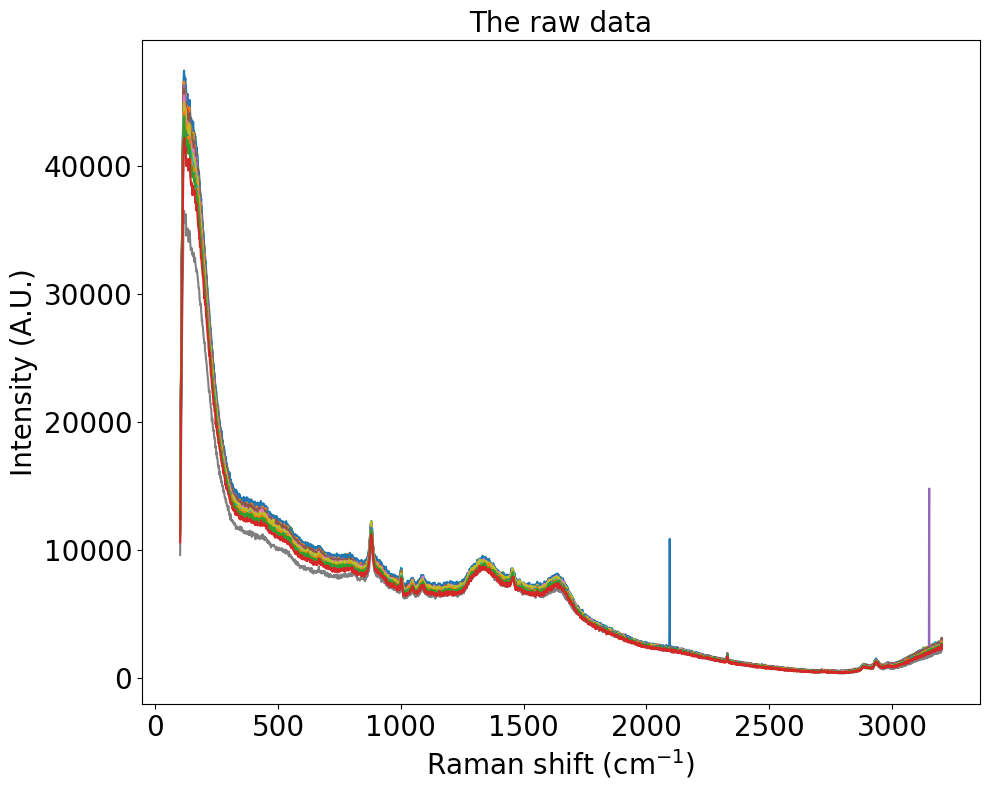

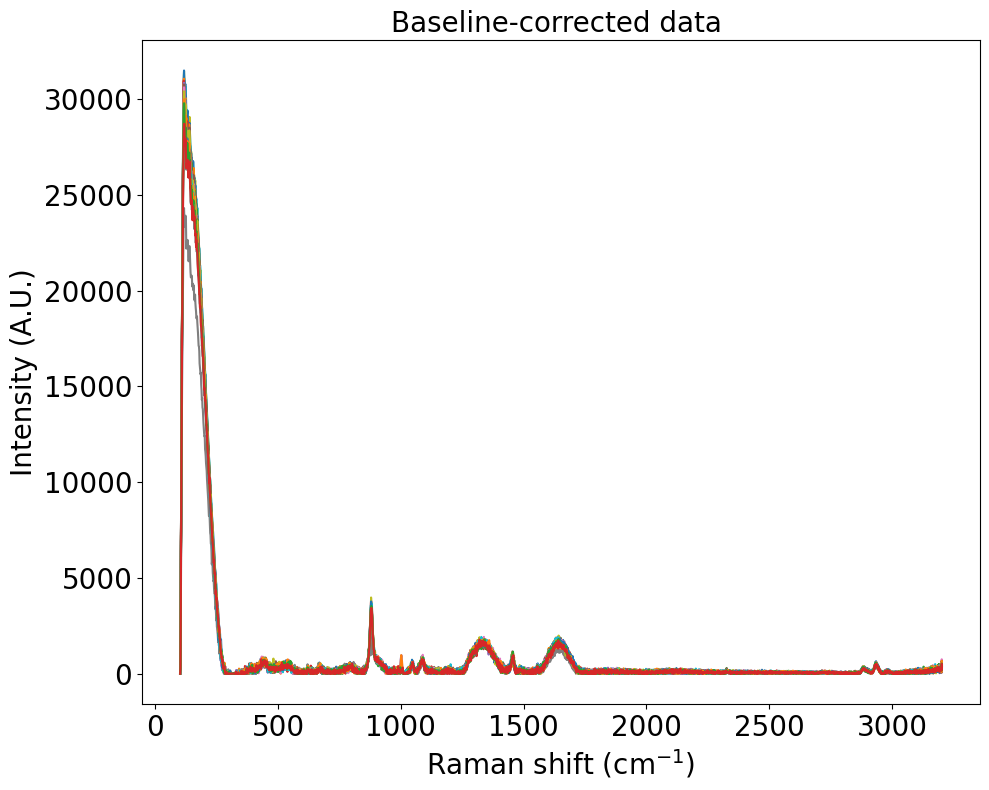

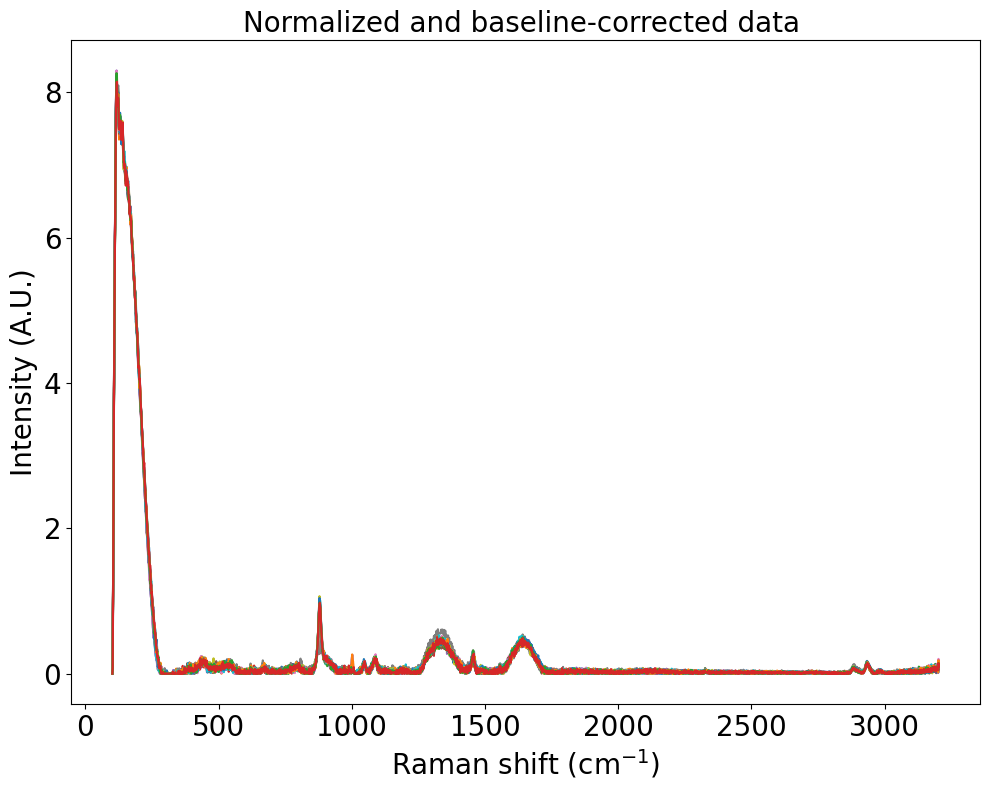

In [ ]:
####Saving the plots

###plotting the baseline-corrected data###
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.subplots(figsize=(10,8))



for i in range(int(len(I_raman_raw))):
    plt.plot(lamb_raman,I_raman_raw[i])

plt.title('The raw data',fontsize=20)

plt.xlabel('Raman shift (cm$^{-1}$)',fontsize=20)
plt.ylabel('Intensity (A.U.)',fontsize=20)
plt.tight_layout()

os.chdir(output_path_plots)

plt.savefig('Raw_signal.png',dpi=500)


###plotting the baseline-corrected data###
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.subplots(figsize=(10,8))



for i in range(int(len(I_baseline_corrected))):
    plt.plot(lamb_raman,I_baseline_corrected[i])


plt.title('Baseline-corrected data ',fontsize=20)

plt.xlabel('Raman shift (cm$^{-1}$)',fontsize=20)
plt.ylabel('Intensity (A.U.)',fontsize=20)
plt.tight_layout()

os.chdir(output_path_plots)

plt.savefig('Baseline_corrected_signal.png',dpi=500)


####plotting the normalized data####
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.subplots(figsize=(10,8))



for i in range(int(len(I_normalized))):
    plt.plot(lamb_raman,I_normalized[i])

plt.title('Normalized and baseline-corrected data ',fontsize=20)

plt.xlabel('Raman shift (cm$^{-1}$)',fontsize=20)
plt.ylabel('Intensity (A.U.)',fontsize=20)
plt.tight_layout()

os.chdir(output_path_plots)

plt.savefig('Normalized_Baseline_corrected_signal.png',dpi=500)



